In [1]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import random
from typing import List, Tuple
from itertools import combinations
from copy import deepcopy

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from levers import IteratedLeverEnvironment
from levers.learner import HistoryShaper, DQNAgent, Transition
from levers.helpers import generate_binary_patterns

In [2]:
# Experiment settings
n_eval_mc = 10
n_train_mc = 3
n_agents = 20

# Final results table
scores = torch.zeros((n_agents, n_agents, n_eval_mc))
greedy_scores = torch.zeros_like(scores)

In [3]:
def eval_oql_xplay(
    a1_train_partners: Tuple[int],
    a1_train_id: int, 
    a2_train_partners: Tuple[int],
    a2_train_id: int,
):
    # Environment parameters
    payoffs = [1., 1.]
    n_iterations = 100

    # Initialize environment without lever game partner
    env = IteratedLeverEnvironment(
        payoffs,
        n_iterations+1, 
        include_payoffs=False,
        include_step=False
    )

    # Initialize history shaper with LSTM net
    hs_output_size=4
    hs1 = HistoryShaper(
        hs_net=nn.LSTM(input_size=len(env.dummy_obs()[0,]), hidden_size=hs_output_size)
    )
    hs2 = deepcopy(hs1)

    # Initialize DQN agent
    l1 = DQNAgent(
        q_net=nn.Sequential(
            nn.Linear(hs_output_size, 4),
            nn.ReLU(),
            nn.Linear(4, env.n_actions())
        ),
        capacity=16,
        batch_size=8,
        lr=0.01
    )
    l2 = deepcopy(l1)

    # Load the models
    models_dir = 'online_qlearner_length3/data'

    model_name1 = f'-net-pattern={a1_train_partners}-eval_id={a1_train_id:02d}.pt'
    hs1.net.load_state_dict(torch.load(os.path.join(models_dir, 'hs' + model_name1)))
    l1.q_net.load_state_dict(torch.load(os.path.join(models_dir, 'q' + model_name1)))
    l1.reset()

    model_name2 = f'-net-pattern={a2_train_partners}-eval_id={a2_train_id:02d}.pt'
    hs2.net.load_state_dict(torch.load(os.path.join(models_dir, 'hs' + model_name2)))
    l2.q_net.load_state_dict(torch.load(os.path.join(models_dir, 'q' + model_name2)))
    l2.reset()

    # Reset environment
    joint_obs = env.reset()

    obs1 = joint_obs[0,]
    obs_rep1, hidden1 = hs1.net(obs1.unsqueeze(0))

    obs2 = joint_obs[1,]
    obs_rep2, hidden2 = hs2.net(obs2.unsqueeze(0))

    # 
    ret = 0

    # Step through environment
    for step in range(n_iterations):
        # Obtain action from learners
        epsilon = 0.2 * max(0, 1 - 4 * step / n_iterations)
        action1, _ = l1.act(obs_rep1.squeeze(0), epsilon=epsilon)
        action2, _ = l2.act(obs_rep2.squeeze(0), epsilon=epsilon)

        # Take step in environment
        joint_next_obs, reward, done = env.step([action1, action2])
        next_obs1 = joint_next_obs[0]
        next_obs2 = joint_next_obs[1]

        # Compute history representation
        next_obs_rep1, next_hidden1 = hs1.net(next_obs1.unsqueeze(0), hidden1)
        next_obs_rep2, next_hidden2 = hs2.net(next_obs2.unsqueeze(0), hidden2)

        # Give experience to learner and train
        l1.update_memory(
            Transition(
                obs_rep1.squeeze(0).detach(),
                action1, 
                next_obs_rep1.squeeze(0).detach(), 
                reward, done
            )
        )
        l1.train(done)
        l2.update_memory(
            Transition(
                obs_rep2.squeeze(0).detach(),
                action2, 
                next_obs_rep2.squeeze(0).detach(), 
                reward, done
            )
        )
        l2.train(done)

        # Update next observation -> observation
        obs_rep1 = next_obs_rep1
        obs_rep2 = next_obs_rep2
        hidden1 = next_hidden1
        hidden2 = next_hidden2

        #
        ret += reward
        
    return ret / 100

In [4]:
patterns = generate_binary_patterns(3)

train_partners = random.sample(list(combinations(patterns, 4)), n_agents)
train_eval = random.choices(range(n_train_mc), k=n_agents)

for a1_idx in range(n_agents):
    print(f'Evaluating OQL {a1_idx:2d} against OQL ', end='')
    for a2_idx in range(n_agents):
        end = '.\n' if a2_idx == n_agents - 1 else ' '
        print(f'{a2_idx}', end=end)
        for eval_id in range(n_eval_mc):
            scores[a1_idx, a2_idx, eval_id] = eval_oql_xplay(
                a1_train_partners=train_partners[a1_idx],
                a1_train_id=train_eval[a1_idx],
                a2_train_partners=train_partners[a2_idx],
                a2_train_id=train_eval[a2_idx],
            )

Evaluating OQL  0 against OQL 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19.
Evaluating OQL  1 against OQL 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19.
Evaluating OQL  2 against OQL 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19.
Evaluating OQL  3 against OQL 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19.
Evaluating OQL  4 against OQL 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19.
Evaluating OQL  5 against OQL 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19.
Evaluating OQL  6 against OQL 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19.
Evaluating OQL  7 against OQL 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19.
Evaluating OQL  8 against OQL 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19.
Evaluating OQL  9 against OQL 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19.
Evaluating OQL 10 against OQL 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19.
Evaluating OQL 11 against OQL 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19.
Evaluating OQL 12 against OQ

In [5]:
train_partners

[((0, 0, 0), (0, 0, 1), (1, 0, 1), (1, 1, 1)),
 ((0, 1, 0), (0, 1, 1), (1, 0, 1), (1, 1, 1)),
 ((0, 0, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1)),
 ((0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1)),
 ((0, 0, 1), (0, 1, 1), (1, 0, 0), (1, 1, 0)),
 ((0, 0, 0), (1, 0, 0), (1, 0, 1), (1, 1, 1)),
 ((0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1)),
 ((0, 0, 1), (0, 1, 1), (1, 0, 0), (1, 1, 1)),
 ((0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0)),
 ((0, 1, 0), (1, 0, 0), (1, 1, 0), (1, 1, 1)),
 ((0, 0, 0), (0, 1, 0), (1, 0, 0), (1, 1, 1)),
 ((0, 1, 0), (1, 0, 0), (1, 0, 1), (1, 1, 1)),
 ((0, 0, 0), (0, 1, 0), (0, 1, 1), (1, 0, 0)),
 ((0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 1, 0)),
 ((0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 1, 1)),
 ((0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 1, 0)),
 ((0, 1, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)),
 ((0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0)),
 ((0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 1, 1)),
 ((0, 0, 0), (0, 0, 1), (0, 1, 0), (1, 0, 0))]

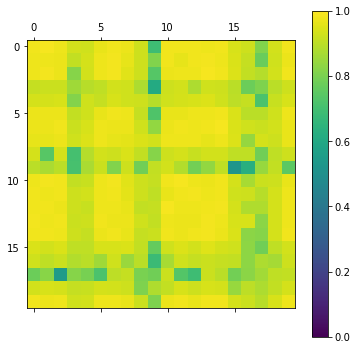

In [6]:
fig, ax = plt.subplots(figsize=(6,6))
cax = ax.matshow(scores.mean(dim=-1), vmin=0, vmax=1)
fig.colorbar(cax)